In [1]:
import json
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import random
import shutil
import glob
import time

from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor, DefaultTrainer,default_argument_parser, default_setup
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.events import EventStorage

from deepent.data.register_datasets import register_datasets
from deepent.config import add_deepent_config
from tools.vis import visualize_single, get_predictions
from tools.train_net import *
from tools.predictor import RGBDPredictor

In [2]:
def find_losses(config, model):
    data_loader = DefaultTrainer.build_train_loader(cfg)
    _data_loader_iter = iter(data_loader)
    losses = {}
    while len(losses.items()) < 10:
        assert model.training, "[SimpleTrainer] model was changed to eval mode!"
        start = time.perf_counter()
        data = next(_data_loader_iter)
        data_time = time.perf_counter() - start
        with EventStorage() as storage:
            loss_dict = model(data)
        if not data[0]["file_name"] in losses:
            losses[data[0]["file_name"]] = {'loss_cls' : loss_dict['loss_cls'].item(),
                        'loss_box_reg' : loss_dict['loss_box_reg'].item(), 'loss_mask' : loss_dict['loss_mask'].item()}
    return losses

def find_metrics(config, model):
    DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
        cfg.MODEL.WEIGHTS, resume=args.resume
    )
    res = Trainer.test(cfg, model,wandb_on=False)
    if comm.is_main_process():
                verify_results(cfg, res)
    return(res)

def register_temporary_datasets(n_from_each_set):
    #create new mini-datasets
        test_tiles = []
        test_tile_segs = []
        for location in glob.glob('/home/ubuntu/RGBD-Training-Data/test/*'):
            filenames = glob.glob(location + '/*.png')
            with open(os.path.join(location,'segs.json'),'r') as segfile:
                segs = json.load(segfile)
                for ind in np.random.randint(0,len(filenames),n_from_each_set):
                    test_tiles.append(filenames[ind])
                    test_tile_segs.append(list(filter(lambda x : x["file_name"]==filenames[ind],segs)))

        test_dir = '/home/ubuntu/RGBD-Training-Data/test/'                
        folder_names = []             
        test_set_names = []
        set_tile_paths = {}
        for i,path in enumerate(test_tiles):
            folder_names.append('temporary_'+str(i))
            test_set_names.append(folder_names[-1] + "_test")
            set_tile_paths[test_set_names[-1]] = path
            os.mkdir(test_dir + folder_names[-1])
            shutil.copy(path, test_dir + folder_names[-1] + '/' + path.split('/')[-1])
            with open(os.path.join(test_dir,folder_names[-1],'segs.json'),'w') as segfile:
                segfile.write(json.dumps(test_tile_segs[i]))
        register_datasets(f'/home/ubuntu/RGBD-Training-Data/')
        return test_set_names, set_tile_paths
    
def remove_temporary_dataset_dirs():
    #remove temporary dirs
    os.chdir('/home/ubuntu/RGBD-Training-Data/test')
    for folder in glob.glob('temporary*'):
        for file in glob.glob(folder + '/*'):
            os.remove(file)
        os.rmdir(folder)   

In [3]:
arg_array = ['--eval-only',
             '--config-file', '/home/ubuntu/drone-tree-id/configs/deepent_fuse_rcnn_R_50_FPN.yaml',
             'OUTPUT_DIR','/home/ubuntu/drone-tree-id/output/baseline_fuse_07_02_2020/ ',
             'MODEL.WEIGHTS', '/home/ubuntu/drone-tree-id/output/baseline_fuse_07_02_2020/model_final.pth']
args = default_argument_parser().parse_args(arg_array)

In [6]:
test_set_names, set_tile_paths = register_temporary_datasets(2)

Registering Kelowna_train
Registering AMECT9_train
Registering SALCT1_train
Registering CPT2b_train
Registering CPT2a-n_train
Registering temporary_0_test
Registering temporary_4_test
Registering temporary_8_test
Registering temporary_7_test
Registering Kelowna_test
Registering AMECT9_test
Registering temporary_2_test
Registering SALCT1_test
Registering CPT2b_test
Registering temporary_1_test
Registering temporary_9_test
Registering temporary_6_test
Registering temporary_5_test
Registering temporary_3_test
Registering CPT2a-n_test


In [7]:
cfg = get_cfg()
add_deepent_config(cfg)
cfg.merge_from_file(args.config_file)
cfg.merge_from_list(args.opts)
cfg.DATASETS.TEST = test_set_names
cfg.DATASETS.TRAIN = test_set_names
cfg.freeze()
default_setup(cfg, args)

# Run Eval

model = Trainer.build_model(cfg)
        
losses = find_losses(cfg, model)
metrics = find_metrics(cfg, model)
losses_and_metrics = {}
for test_set_name in test_set_names:
    losses_and_metrics[test_set_name] = {'losses': losses[set_tile_paths[test_set_name]], 'metrics': metrics[test_set_name]}

[03/28 00:23:24 detectron2]: Rank of current process: 0. World size: 1
[03/28 00:23:24 detectron2]: Environment info:
------------------------  --------------------------------------------------------------------------------------
sys.platform              linux
Python                    3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) [GCC 7.2.0]
numpy                     1.15.4
detectron2                0.1.1 @/home/ubuntu/drone-tree-id/lib/detectron2/detectron2
detectron2 compiler       GCC 5.4
detectron2 CUDA compiler  10.1
detectron2 arch flags     sm_75
DETECTRON2_ENV_MODULE     <not set>
PyTorch                   1.4.0 @/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch
PyTorch debug build       False
CUDA available            True
GPU 0                     Tesla T4
CUDA_HOME                 /usr/local/cuda-10.1
NVCC                      Cuda compilation tools, release 10.1, V10.1.243
Pillow                    5.4.1
torchvision               0.5.0 @

[03/28 00:23:24 detectron2]: Full config saved to /home/ubuntu/drone-tree-id/output/baseline_fuse_07_02_2020/ /config.yaml
[03/28 00:23:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): FusedResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride

[03/28 00:23:28 d2.data.build]: Removed 0 images with no usable annotations. 10 images left.
[03/28 00:23:28 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| deciduous  | 4            | coniferous | 476          |    dead    | 2            |
|            |              |            |              |            |              |
|   total    | 482          |            |              |            |              |
[03/28 00:23:28 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[03/28 00:23:28 d2.data.common]: Serialized dataset takes 0.13 MiB
[03/28 00:23:28 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(600, 640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/28 00:23:28 d2.dat

[03/28 00:23:32 d2.data.common]: Serialized dataset takes 0.00 MiB
WARNING [03/28 00:23:32 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'temporary_1_test'. Trying to convert it to COCO format ...
[03/28 00:23:32 d2.data.datasets.coco]: Converting annotations of dataset 'temporary_1_test' to COCO format ...)
[03/28 00:23:32 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/28 00:23:32 d2.data.datasets.coco]: Conversion finished, num images: 1, num annotations: 13
[03/28 00:23:32 d2.data.datasets.coco]: Caching COCO format annotations at '/home/ubuntu/drone-tree-id/output/baseline_fuse_07_02_2020/ /inference/temporary_1_test_coco_format.json' ...
[03/28 00:23:32 d2.evaluation.evaluator]: Start inference on 1 images
[03/28 00:23:33 d2.evaluation.evaluator]: Total inference time: 0:00:00.259894 (0.259894 s / img per device, on 1 devices)
[03/28 00:23:33 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.131993 s / i

[03/28 00:23:34 d2.evaluation.coco_evaluation]: Note that some metrics cannot be computed.
[03/28 00:23:34 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP    | category   | AP   |
|:-----------|:-----|:-----------|:------|:-----------|:-----|
| deciduous  | nan  | coniferous | 0.000 | dead       | nan  |
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50

[03/28 00:23:34 d2.evaluation.testing]: copypaste: Task: bbox
[03/28 00:23:34 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[03/28 00:23:34 d2.evaluation.testing]: copypaste: 0.0676,0.6757,0.0000,nan,0.1429,0.0000
[03/28 00:23:34 d2.evaluation.testing]: copypaste: Task: segm
[03/28 00:23:34 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[03/28 00:23:34 d2.evaluation.testing]: copypaste: 0.0000,0.0000,0.0000,nan,0.0000,0.0000
[03/28 00:23:34 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| deciduous  | 0            | coniferous | 67           |    dead    | 0            |
|            |              |            |              |            |              |
|   total    | 67           |            |              |            |              |
[03/28 00:23:34 d2.data.common]:

[03/28 00:23:35 d2.evaluation.evaluator]: Total inference time: 0:00:00.306690 (0.306690 s / img per device, on 1 devices)
[03/28 00:23:35 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.143842 s / img per device, on 1 devices)
[03/28 00:23:35 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/28 00:23:35 d2.evaluation.coco_evaluation]: Saving results to /home/ubuntu/drone-tree-id/output/baseline_fuse_07_02_2020/ /inference/coco_instances_results.json
[03/28 00:23:35 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area= 

[03/28 00:23:36 d2.evaluation.coco_evaluation]: Note that some metrics cannot be computed.
[03/28 00:23:36 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP    | category   | AP   |
|:-----------|:-----|:-----------|:------|:-----------|:-----|
| deciduous  | nan  | coniferous | 0.000 | dead       | nan  |
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50

[03/28 00:23:37 d2.evaluation.testing]: copypaste: Task: bbox
[03/28 00:23:37 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[03/28 00:23:37 d2.evaluation.testing]: copypaste: 0.0000,0.0000,0.0000,nan,0.0000,0.0000
[03/28 00:23:37 d2.evaluation.testing]: copypaste: Task: segm
[03/28 00:23:37 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[03/28 00:23:37 d2.evaluation.testing]: copypaste: 0.0000,0.0000,0.0000,nan,0.0000,0.0000
[03/28 00:23:37 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[03/28 00:23:37 d2.data.common]: Serialized dataset takes 0.02 MiB
WARNING [03/28 00:23:37 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'temporary_8_test'. Trying to convert it to COCO format ...
[03/28 00:23:37 d2.data.datasets.coco]: Converting annotations of dataset 'temporary_8_test' to COCO format ...)
[03/28 00:23:37 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/28 00:23:37 

[03/28 00:23:38 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] =

[03/28 00:26:54 fvcore.common.checkpoint]: Loading checkpoint from /home/ubuntu/drone-tree-id/output/baseline_fuse_07_02_2020/model_final.pth


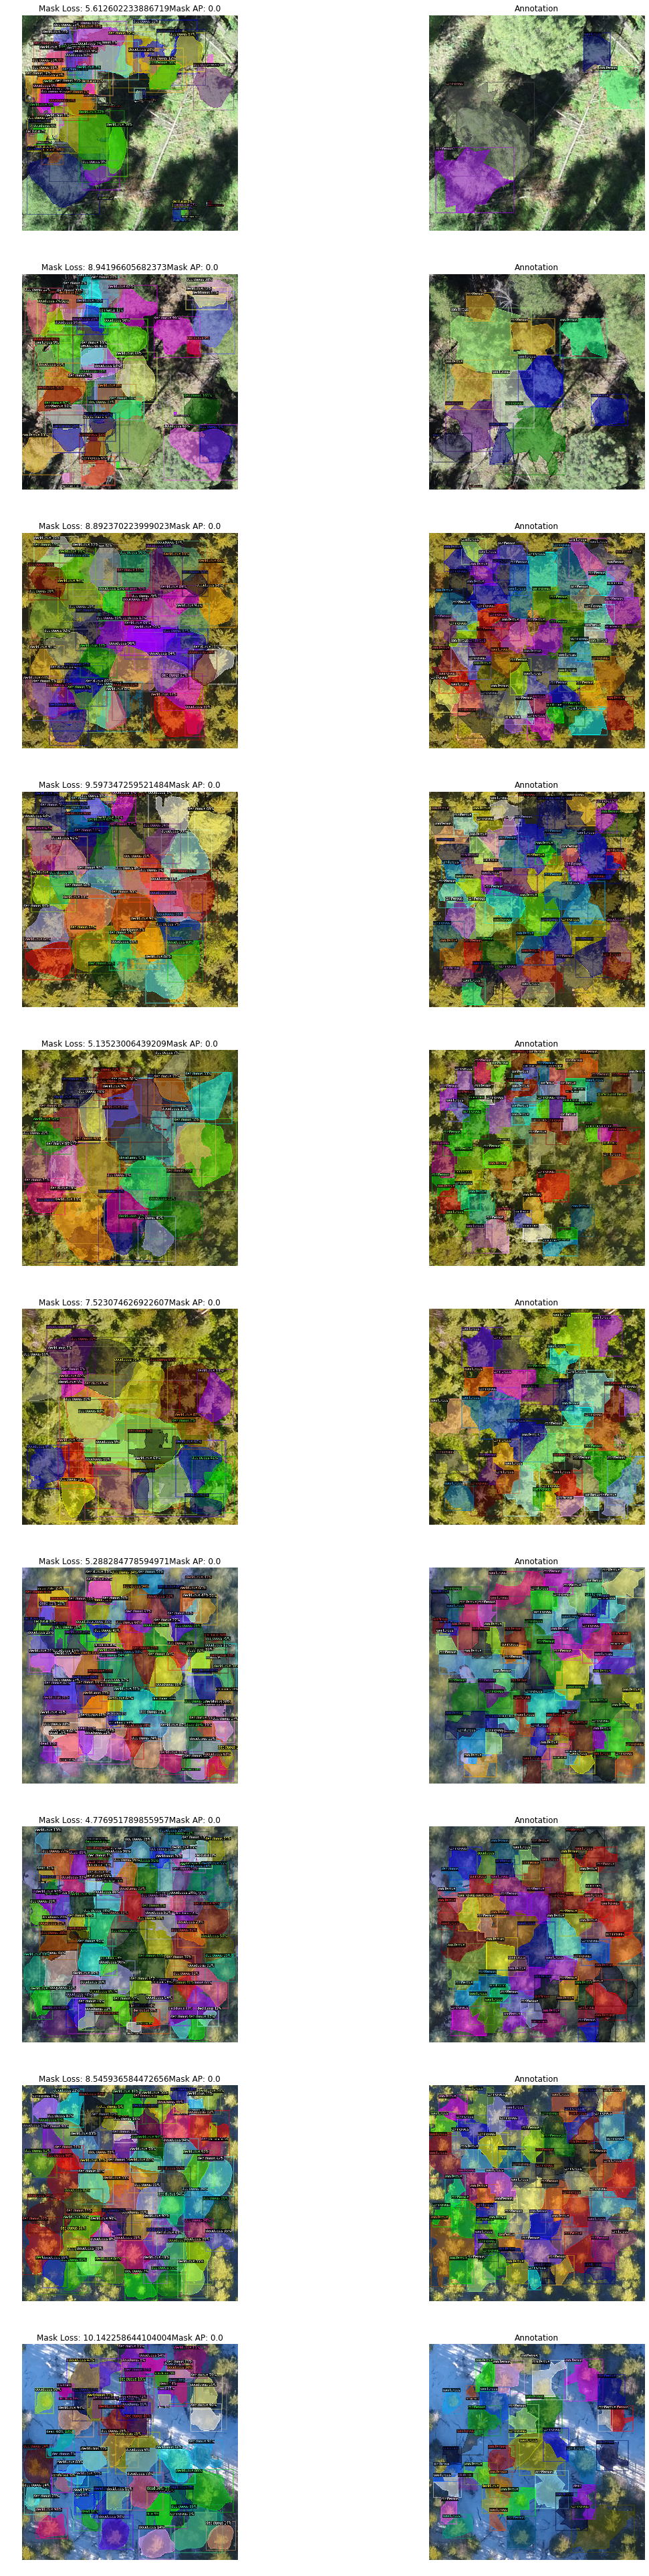

In [10]:
#Visualize with different models and show evals
predictor = RGBDPredictor(cfg)
fig,axes = plt.subplots(10,2,figsize=(20,70))
ax = axes.ravel()
i=0
for test_set_name in test_set_names:
    data = list(DatasetCatalog.get(test_set_name))
    metadata = MetadataCatalog.get(test_set_name)
    dic = data[0]
    img, predictions = get_predictions(predictor,set_tile_paths[test_set_name])
    visualizer = Visualizer(img, metadata=metadata)
    for ind, cls in enumerate(predictions['instances'].pred_classes):
        if cls ==3:
            predictions['instances'].pred_classes[ind] = 2    
    vis = visualizer.draw_instance_predictions(predictions["instances"].to("cpu")).get_image()
    title = "Mask Loss: " + str(losses_and_metrics[test_set_name]['losses']['loss_mask']) + "Mask AP: " + str(losses_and_metrics['temporary_0_test']['metrics']['segm']['AP'])
    ax[i].set_title(title)
    ax[i].axis('off')
    ax[i].imshow(vis)
    i+=1
    visualizer2 = Visualizer(img, metadata=metadata)
    vis2 = visualizer2.draw_dataset_dict(dic).get_image()
    ax[i].set_title('Annotation')
    ax[i].axis('off')
    ax[i].imshow(vis2)
    i+=1

In [5]:
remove_temporary_dataset_dirs()

In [11]:
metrics

OrderedDict([('temporary_0_test',
              OrderedDict([('bbox',
                            {'AP': 0.0,
                             'AP50': 0.0,
                             'AP75': 0.0,
                             'APs': nan,
                             'APm': 0.0,
                             'APl': 0.0,
                             'AP-deciduous': nan,
                             'AP-coniferous': 0.0,
                             'AP-dead': nan}),
                           ('segm',
                            {'AP': 0.0,
                             'AP50': 0.0,
                             'AP75': 0.0,
                             'APs': nan,
                             'APm': 0.0,
                             'APl': 0.0,
                             'AP-deciduous': nan,
                             'AP-coniferous': 0.0,
                             'AP-dead': nan})])),
             ('temporary_1_test',
              OrderedDict([('bbox',
                            {'A